## Proses Instalasi

In [1]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Using cached tensorflow-1.13.1-cp36-cp36m-macosx_10_11_x86_64.whl (71.6 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
ERROR: Cannot uninstall tensorflow 1.14.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps tensorflow==1.14.0'.
     |████████████████████████████████| 13.9 MB 5.5 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5


    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.4.1 requires importlib-metadata<4,>=3; python_version < "3.8", but you have importlib-metadata 4.8.3 which is incompatible.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/7q/ssgvc_153p3cclv0gvrlyk300000gn/T/pip-req-build-ivjrekec
  Running command git clone --filter=blob:none -q https://www.github.com/keras-team/keras-contrib.git /private/var/folders/7q/ssgvc_153p3cclv0gvrlyk300000gn/T/pip-req-build-ivjrekec
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [1]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [2]:
import sys
import os
import json
import numpy as np
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

Using TensorFlow backend.


## Prapemrosesan Data

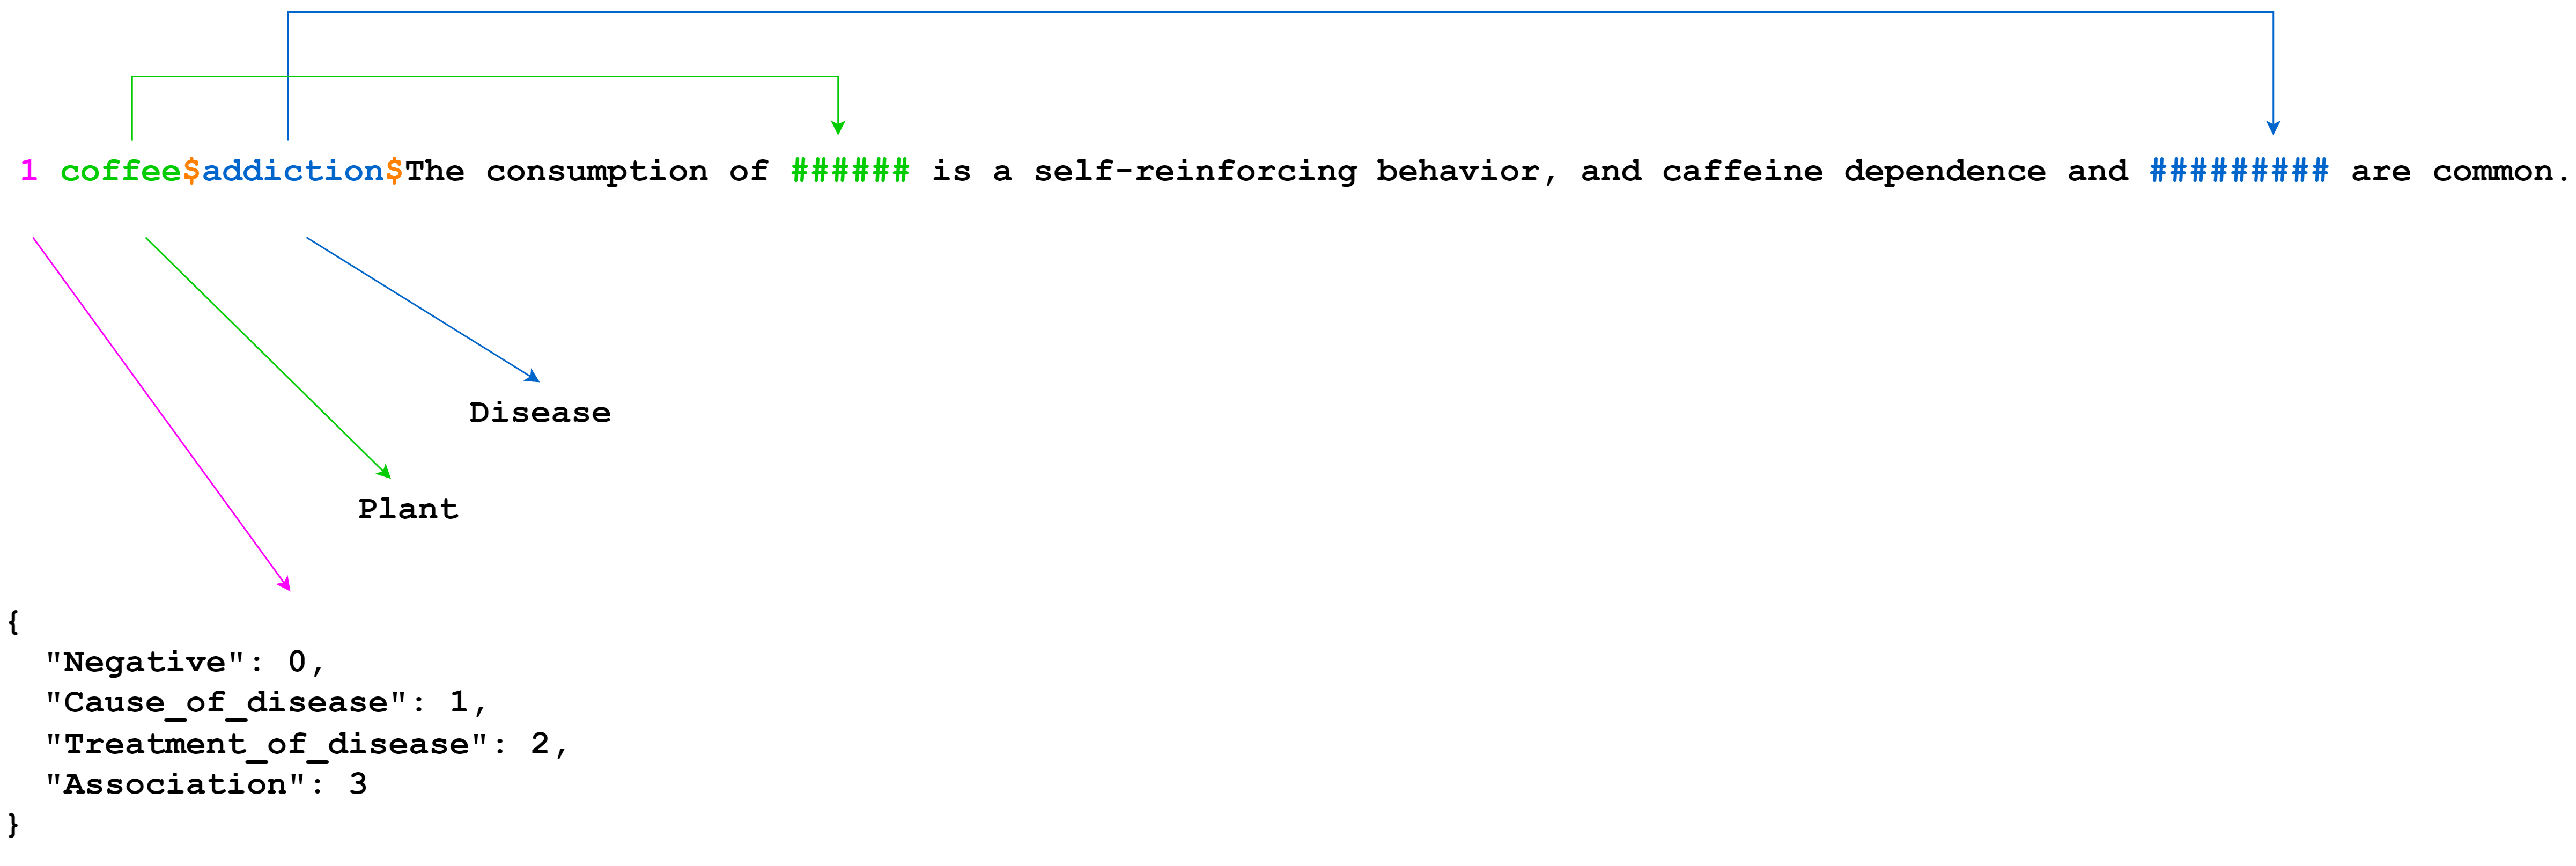

In [3]:
from IPython import display
display.Image("XtoT.png")

In [4]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [5]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split

# Train

### Encoding Process Ratio 80:20

In [ ]:
train_df, test_df = get_train_test_pd()
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)
print('begin encoding')
f = lambda text: bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_df['x'] = train_df['text'].apply(f)
test_df['x'] = test_df['text'].apply(f)

# Combine train and test sets
df = pd.concat([train_df, test_df], axis=0)

# Split combined data into train and test sets with ratio 80:20
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Split train and test labels
train_labels = train_data['label'].values
test_labels = test_data['label'].values

# Remove text and label columns from train and test data
train_data = train_data.drop(columns=['text', 'label'])
test_data = test_data.drop(columns=['text', 'label'])

print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


begin encoding


In [5]:
#train_df, test_df = get_train_test_pd()
#bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)
#print('begin encoding')
#f = lambda text: bert_model.encode([text])["encodes"][0]

#train_df['x'] = train_df['text'].apply(f)
#test_df['x'] = test_df['text'].apply(f)
#print('end encoding')

### Training and Test Set

In [6]:
x_train = np.array([vec for vec in train_df['x']])
x_test = np.array([vec for vec in test_df['x']])
y_train = np.array([vec for vec in train_df['label']])
y_test = np.array([vec for vec in test_df['label']])

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (1046, 512, 768)
y_train:  (1046,)
x_test:  (261, 512, 768)
y_test:  (261,)


In [7]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [8]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (1046, 512, 768)
Size of training output data :  (1046, 4)
Size of testing input data :  (261, 512, 768)
Size of testing output data :  (261, 4)


## Model Config

In [11]:
#inputs = Input(name="Input", shape=(512, 768, ))
#bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)

#crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
#dense = Dense(num_classes, activation='softmax', input_dim=32, kernel_initializer='normal', name="Output")(crf)

#model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")


inputs = Input(name="Input", shape=(512, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [12]:
# If there are .hdf5 files in the original models folder, delete them all
#model_dir = 'output/fold0/8-0,7-7'
#if os.listdir(model_dir):
    #for file in os.listdir(model_dir):
        #os.remove(os.path.join(model_dir, file))

## Model Visualization

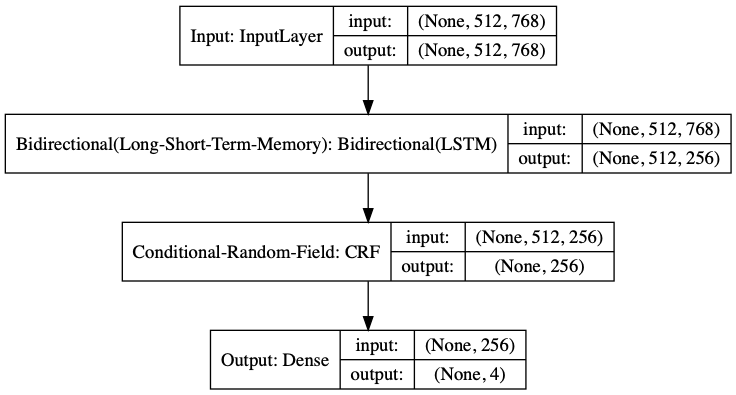

In [13]:
plot_model(model, to_file='model.png', show_shapes=True)

# Model Process

In [14]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 512, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1540      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 921,096
Trainable params: 921,096
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [36]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Scheme1

In [28]:
# Save the latest val_acc best model file
filepath="output/e40-dr03-b64/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [29]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/40
1046/1046 [==============================] - 37s 35ms/step - loss: 0.0448 - accuracy: 0.9723 - val_loss: 1.1759 - val_accuracy: 0.7586

Epoch 00001: val_accuracy improved from -inf to 0.75862, saving model to output/e40-dr3-64-2-7/e-01-los-1.1759-acc-0.7586.hdf5
Epoch 2/40
1046/1046 [==============================] - 41s 39ms/step - loss: 0.0445 - accuracy: 0.9704 - val_loss: 1.2275 - val_accuracy: 0.7548

Epoch 00002: val_accuracy did not improve from 0.75862
Epoch 3/40
1046/1046 [==============================] - 37s 36ms/step - loss: 0.0434 - accuracy: 0.9713 - val_loss: 1.2773 - val_accuracy: 0.7510

Epoch 00003: val_accuracy did not improve from 0.75862
Epoch 4/40
1046/1046 [==============================] - 37s 36ms/step - loss: 0.0485 - accuracy: 0.9665 - val_loss: 1.2473 - val_accuracy: 0.7625

Epoch 00004: val_accuracy improved from 0.75862 to 0.76245, saving model to output/e40-dr3-64-2-7/e-04-los-1.2473-acc-0.7625.hdf

In [37]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

261/261 [==============================] - 4s 17ms/step
The effect on the test set： [0.19114757018071024, 0.9291187524795532]


# Statistik e=40, dr=0.3, batch=64

In [30]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [36]:
model = load_model(
  "output/e10-dr3-20b/epoch-07-val_los-0.3941-acc-0.8212.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=64)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.81      0.92      0.86       118
    Cause_of_disease       0.94      0.84      0.89        37
Treatment_of_disease       0.91      0.85      0.88        98
         Association       1.00      0.25      0.40         8

            accuracy                           0.86       261
           macro avg       0.91      0.71      0.76       261
        weighted avg       0.87      0.86      0.86       261



## Epoch=40, drop=0,3

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


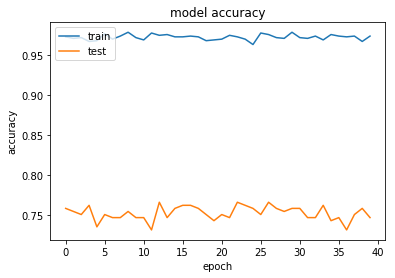

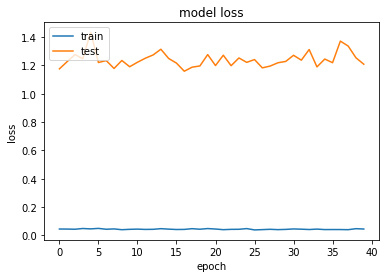

In [34]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.175922      0.758621  0.044831  0.972275
1   1.227507      0.754789  0.044531  0.970363
2   1.277269      0.750958  0.043387  0.971319
3   1.247272      0.762452  0.048534  0.966539
4   1.434564      0.735632  0.045831  0.967495
5   1.220835      0.750958  0.049296  0.976099
6   1.234331      0.747126  0.043276  0.969407
7   1.178781      0.747126  0.045612  0.973231
8   1.235224      0.754789  0.040096  0.978011
9   1.190984      0.747126  0.042716  0.971319
10  1.222516      0.747126  0.044125  0.968451
11  1.250898      0.731801  0.042107  0.977055
12  1.274035      0.766284  0.042810  0.974187
13  1.314511      0.747126  0.047355  0.975143
14  1.249262      0.758621  0.044058  0.972275
15  1.216580      0.762452  0.041552  0.972275
16  1.159183      0.762452  0.042162  0.973231
17  1.187864      0.758621  0.047265  0.972275
18  1.196468      0.750958  0.043477  0.967495
19  1.276832      0.743295  0.048118  0.968451
20  1.199294 

### Chart Loss and Accuracy

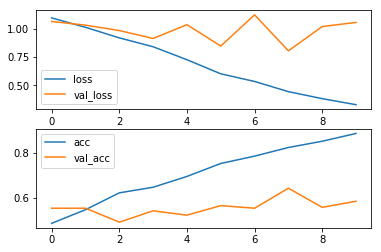

In [50]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("output/loss_acc.png")

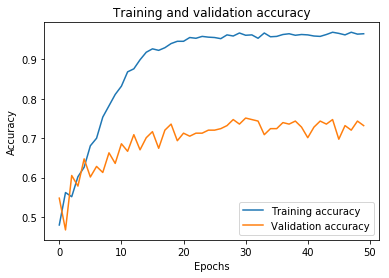

In [27]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict

In [51]:
! python model_predict.py

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2022-09-16 16:52:46.710520: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Use tf.cast instead.
tobacco$lung cancer$In conclusion, variation in ########### rates between populations may be due to: (1) differences in effective exposure to ####### smoke carcinogens; (2) differences in factors which modify the effect of ####### smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for ###########.
I:BERT_VEC:[graph:opt: 48]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 54]:build graph...

For more information, please see:
  * https://github.com/tensorflow/community/blob/